
{{title_its_nb3}}

{{intro}}

In the previous notebook, we worked through challenges that can be associated with working with larger-than-memory datasets. Here, we'll start where we left off, with a dataset that is organized in chronological order, and has a chunking strategy applied. 

In this notebook, we introduce vector data that describes spatial features that we're interested in. This notebook will:
- Look at how to parse and inspect important geographic metadata,   
- Project data to match the coordinate referese system (CRS) of another data object,  
- Join raster and vector data by clipping the raster data cube by the spatial extent of a vector data frame.  
- Write this clipped raster object to disk. 

{{outline}}

(content.Section_B)=
**[B. Incorporate glacier outline (vector) data](#b-incorporate-glacier-outline-vector-data)**
- {{b1_its_nb2}}
- {{b2_its_nb2}}
- {{b3_its_nb2}}

(content.Section_C)=
**[C. Join raster and vector data - single glacier](#c-join-raster-and-vector-data---single-glacier)**
- {{c1_its_nb2}}
- {{c2_its_nb2}}

## todo
adjust intro to reflect split btw prev notebook and this
- ie we decided on this approach to read the data and sort along time dim...
- update outline to reflect this too


In [1]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj

import itslivetools

In [2]:
url = itslivetools.find_granule_by_point([95.180191, 30.645973])

dc = itslivetools.read_in_s3(url, chunks=None)
dc

<xarray.Dataset> Size: 1TB
Dimensions:                     (mid_date: 47892, y: 833, x: 833)
Coordinates:
    mapping                     <U1 4B ...
  * mid_date                    (mid_date) datetime64[ns] 383kB 2022-06-07T04...
  * x                           (x) float64 7kB 7.001e+05 7.003e+05 ... 8e+05
  * y                           (y) float64 7kB 3.4e+06 3.4e+06 ... 3.3e+06
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 133GB ...
    M11_dr_to_vr_factor         (mid_date) float32 192kB ...
    M12                         (mid_date, y, x) float32 133GB ...
    M12_dr_to_vr_factor         (mid_date) float32 192kB ...
    acquisition_date_img1       (mid_date) datetime64[ns] 383kB ...
    acquisition_date_img2       (mid_date) datetime64[ns] 383kB ...
    ...                          ...
    vy_error_modeled            (mid_date) float32 192kB ...
    vy_error_slow               (mid_date) float32 192kB ...
    vy_error_stationary         (mid_date) float32 192kB ...
    vy_stable_shift             (mid_date) float32 192kB ...
    vy_stable_shift_slow        (mid_date) float32 192kB ...
    vy_stable_shift_stationary  (mid_date) float32 192kB ...
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [3]:
dc = dc.sortby("mid_date")
dc.mid_date

<xarray.DataArray 'mid_date' (mid_date: 47892)> Size: 383kB
array(['1986-09-11T03:31:15.003252992', '1986-10-05T03:31:06.144750016',
       '1986-10-21T03:31:34.493249984', ..., '2024-10-29T04:18:09.241024000',
       '2024-10-29T04:18:09.241024000', '2024-10-29T04:18:09.241024000'],
      dtype='datetime64[ns]')
Coordinates:
    mapping   <U1 4B ...
  * mid_date  (mid_date) datetime64[ns] 383kB 1986-09-11T03:31:15.003252992 ....
Attributes:
    description:    midpoint of image 1 and image 2 acquisition date and time...
    standard_name:  image_pair_center_date_with_time_separation

In [2]:
chunking_dict = {
    "mid_date": (32736, 15156),
    "y": (
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        13,
    ),
    "x": (
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        13,
    ),
}

In [5]:
dc = dc.chunk(chunking_dict)

In [6]:
dc.chunks

Frozen({'mid_date': (32736, 15156), 'y': (20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 13), 'x': (20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 13)})

## B. Incorporate glacier outline (vector) data

### {{b1_its_nb2}}

As discussed in the [Software and Data](software_and_data.ipynb#RGI) notebook, the examples in this tutorial use glacier outlines from the Randolph Glacier Inventory, version 7 (RGI7). We'll specifically be looking at the 'South Asia East' region.

In [8]:
se_asia = gpd.read_parquet("../data/tutorial1/rgi7_region15_south_asia_east.parquet")

It is **vital** to check the CRS, or Coordinate Reference Systems, when combining geospatial data from different sources. 

The RGI data are in the `EPSG:4326` CRS.

In [9]:
se_asia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The CRS information for the ITS_LIVE dataset is stored in the `mapping` array. An easy way to discover this is to use the `cf_xarray` package and search for the `grid_mapping` variable if present.

In [10]:
dc.cf

Coordinates:
             CF Axes: * X: ['x']
                      * Y: ['y']
                        Z, T: n/a

      CF Coordinates:   longitude, latitude, vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names: * image_pair_center_date_with_time_separation: ['mid_date']
                      * projection_x_coordinate: ['x']
                      * projection_y_coordinate: ['y']

              Bounds:   n/a

       Grid Mappings:   universal_transverse_mercator: ['mapping']

Data Variables:
       Cell Measures:   area, volume: n/a

      Standard Names:   M11_dr_to_vr_factor: ['M11_dr_to_vr_factor']
                        M12_dr_to_vr_factor: ['M12_dr_to_vr_factor']
                        autoRIFT_software_version: ['autoRIFT_software_version']
                        chip_size_height: ['chip_size_height']
                        chip_size_width: ['chip_size_width']
                        conversion_matrix_element_11: ['M11']
                       

In [11]:
cube_crs = pyproj.CRS.from_cf(dc.mapping.attrs)
cube_crs

<Projected CRS: EPSG:32646>
Name: WGS 84 / UTM zone 46N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 46N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

This indicates that the data is projected to UTM zone 46N (EPSG:32646).

We choose to reproject the glacier outline to the CRS of the datacube:

In [12]:
# Project rgi data to match itslive
se_asia_prj = se_asia.to_crs(cube_crs)
se_asia_prj.head(3)

rgi_id o1region o2region        glims_id  anlys_id  \
0  RGI2000-v7.0-G-15-00001       15    15-01  G078088E31398N    866850   
1  RGI2000-v7.0-G-15-00002       15    15-01  G078125E31399N    867227   
2  RGI2000-v7.0-G-15-00003       15    15-01  G078128E31390N    867273   

   subm_id             src_date     cenlon     cenlat  utm_zone  ...  \
0      752  2002-07-10T00:00:00  78.087891  31.398046        44  ...   
1      752  2002-07-10T00:00:00  78.123699  31.397796        44  ...   
2      752  2000-08-05T00:00:00  78.128510  31.390287        44  ...   

      zmin_m     zmax_m     zmed_m    zmean_m  slope_deg  aspect_deg  \
0  4662.2950  4699.2095  4669.4720  4671.4253  13.427070  122.267290   
1  4453.3584  4705.9920  4570.9473  4571.2770  22.822983  269.669144   
2  4791.7593  4858.6807  4832.1836  4827.6700  15.626262  212.719681   

   aspect_sec  dem_source  lmax_m  \
0           4    COPDEM30     173   
1           7    COPDEM30    1113   
2           6    COPDEM30     327   

                                            geometry  
0  POLYGON Z ((-924868.476 3571663.111 0.000, -92...  
1  POLYGON Z ((-921270.161 3571706.471 0.000, -92...  
2  POLYGON Z ((-921061.745 3570342.665 0.000, -92...  

[3 rows x 29 columns]

How many glaciers are represented in the dataset?

In [13]:
len(se_asia_prj)

18587

#### Visualize spatial extents of glacier outlines and ITS_LIVE granule

In [Accessing S3 Data](accessing_s3_data.ipynb), we defined a function to create a vector object describing the footprint of a raster object; we'll use that again here.

## TODO
make sure text on objects and CRS and bbox_dc etc is correct and has up to date names 


In [14]:
# Get vector bbox of itslive
bbox_dc = itslivetools.get_bounds_polygon(dc)
bbox_dc["geometry"]
# Check that all objects have correct crs
assert dc.attrs["projection"] == bbox_dc.crs == se_asia_prj.crs

<Axes: >

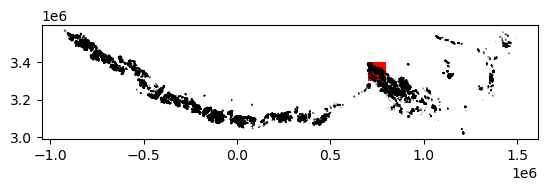

In [15]:
# Plot the outline of the itslive granule and the rgi dataframe together
fig, ax = plt.subplots()

bbox_dc.plot(ax=ax, facecolor="None", color="red")
se_asia_prj.plot(ax=ax, facecolor="None")

### {{b2_its_nb2}}

The above plot shows the coverage of the vector dataset, in black, relative to the extent of the raster dataset, in red. We use the [geopandas `.clip()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.clip.html) method to subset the RGI polygons (`se_asia_prj`) to the footprint of the ITS_LIVE (`bbox_dc`) datacube.

In [16]:
# Subset rgi to bounds
se_asia_subset = gpd.clip(se_asia_prj, bbox_dc)
se_asia_subset.head()

rgi_id o1region o2region        glims_id  anlys_id  \
16373  RGI2000-v7.0-G-15-16374       15    15-03  G095930E29817N    930178   
16374  RGI2000-v7.0-G-15-16375       15    15-03  G095925E29818N    930160   
16376  RGI2000-v7.0-G-15-16377       15    15-03  G095915E29820N    930107   
16371  RGI2000-v7.0-G-15-16372       15    15-03  G095936E29819N    930215   
15879  RGI2000-v7.0-G-15-15880       15    15-03  G095459E29807N    928789   

       subm_id             src_date     cenlon     cenlat  utm_zone  ...  \
16373      752  2005-09-08T00:00:00  95.929916  29.817003        46  ...   
16374      752  2005-09-08T00:00:00  95.925181  29.818399        46  ...   
16376      752  2005-09-08T00:00:00  95.914583  29.819510        46  ...   
16371      752  2005-09-08T00:00:00  95.935554  29.819123        46  ...   
15879      752  1999-07-29T00:00:00  95.459374  29.807181        46  ...   

          zmin_m     zmax_m     zmed_m    zmean_m  slope_deg  aspect_deg  \
16373  4985.7314  5274.0435  5142.7660  5148.8170  27.024134  139.048110   
16374  4856.2790  5054.9253  4929.5560  4933.6890  44.126980  211.518448   
16376  5072.8910  5150.6196  5108.5020  5111.7217  23.980000  219.341537   
16371  4838.7646  5194.8840  5001.5117  4992.3706  25.684517  128.737870   
15879  3802.1846  4155.1255  4000.2695  4000.4404  28.155806  116.148640   

       aspect_sec  dem_source  lmax_m  \
16373           4    COPDEM30     756   
16374           6    COPDEM30     366   
16376           6    COPDEM30     170   
16371           4    COPDEM30     931   
15879           4    COPDEM30     776   

                                                geometry  
16373  POLYGON Z ((783110.719 3302487.481 0.000, 7831...  
16374  POLYGON Z ((782511.360 3302381.154 0.000, 7825...  
16376  POLYGON Z ((781619.822 3302305.074 0.000, 7816...  
16371  POLYGON Z ((783420.055 3302493.804 0.000, 7834...  
15879  POLYGON Z ((737667.211 3300277.169 0.000, 7377...  

[5 rows x 29 columns]

In [17]:
bbox_dc.to_file("../data/tutorial1/bbox_dc.geojson")

We can use the `geopandas` `.explore()` method to interactively look at the RGI7 outlines contained within the ITS_LIVE granule:

In [18]:
m = folium.Map(
    max_lat=31, max_lon=95, min_lat=29, min_lon=97, location=[30.2, 95.5], zoom_start=8
)

bbox_dc.explore(
    m=m,
    style_kwds={"fillColor": "None", "color": "red"},
    legend_kwds={"labels": ["ITS_LIVE granule footprint"]},
)
se_asia_subset.explore(m=m)

folium.LayerControl().add_to(m)
m

/home/emmamarshall/miniforge3/envs/itslive_tutorial_env/lib/python3.11/site-packages/folium/features.py:1102: UserWarning: GeoJsonTooltip is not configured to render for GeoJson GeometryCollection geometries. Please consider reworking these features: [{'rgi_id': 'RGI2000-v7.0-G-15-16433', 'o1region': '15', 'o2region': '15-03', 'glims_id': 'G095721E29941N', 'anlys_id': 929520, 'subm_id': 752, 'src_date': '2005-09-08T00:00:00', 'cenlon': 95.7211016152286, 'cenlat': 29.940902187781784, 'utm_zone': 46, 'area_km2': 0.340954350813452, 'primeclass': 0, 'conn_lvl': 0, 'surge_type': 0, 'term_type': 9, 'glac_name': None, 'is_rgi6': 0, 'termlon': 95.72222864596793, 'termlat': 29.937137080413784, 'zmin_m': 4657.792, 'zmax_m': 5049.5625, 'zmed_m': 4825.1104, 'zmean_m': 4839.4185, 'slope_deg': 23.704372, 'aspect_deg': 145.20973, 'aspect_sec': 4, 'dem_source': 'COPDEM30', 'lmax_m': 891}, {'rgi_id': 'RGI2000-v7.0-G-15-12194', 'o1region': '15', 'o2region': '15-03', 'glims_id': 'G095869E30315N', 'anlys_

We can use the above interactive map to select a glacier to look at in more detail below.

Notice that while the above code correctly produces a plot, it also throws an warning. We're going to ignore the warning for now, but if you're interested in a detailed example of how to trouble shoot and resolve this type of warning, check out the [appendix](../pt4/appendix.md).

We write `bbox_dc` to file so that we can use it in the appendix

In [19]:
bbox_dc.to_file("../data/tutorial1/bbox_dc.geojson")

## C. Combining raster and vector data - single glacier

### {{c1_its_nb2}}

If we want to dig in and analyze this velocity dataset at smaller spatial scales, we first need to subset it. The following section and the next notebook ([Single Glacier Data Analysis](single_glacier_data_inspection.ipynb)) will focus on the spatial scale of a single glacier. 

In [20]:
# Select a  glacier to subset to
single_glacier_vec = se_asia_subset.loc[
    se_asia_subset["rgi_id"] == "RGI2000-v7.0-G-15-16257"
]
single_glacier_vec

rgi_id o1region o2region        glims_id  anlys_id  \
16256  RGI2000-v7.0-G-15-16257       15    15-03  G095962E29920N    930314   

       subm_id             src_date     cenlon     cenlat  utm_zone  ...  \
16256      752  2005-09-08T00:00:00  95.961972  29.920094        46  ...   

          zmin_m   zmax_m    zmed_m    zmean_m  slope_deg  aspect_deg  \
16256  4320.7065  5937.84  5179.605  5131.8877  22.803406  100.811325   

       aspect_sec  dem_source  lmax_m  \
16256           3    COPDEM30    5958   

                                                geometry  
16256  POLYGON Z ((788176.951 3315860.842 0.000, 7882...  

[1 rows x 29 columns]

In [21]:
# Write it to file to that it can be used later
single_glacier_vec.to_file(
    "../data/tutorial1/single_glacier_vec.json", driver="GeoJSON"
)

Check to see if the ITS_LIVE raster dataset has an assigned CRS attribute. We already know that the data is projected in the correct coordinate reference system (CRS), but the object may not be 'CRS-aware' yet (ie. have an attribute specifying its CRS). This is necessary for spatial operations such as clipping and reprojection. If `dc_rechunk` doesn't have a CRS attribute, use `rio.write_crs()` to assign it. For more detail, see Rioxarray's [CRS Management documentation](https://corteva.github.io/rioxarray/stable/getting_started/crs_management.html).

In [22]:
dc.rio.crs

CRS.from_epsg(32646)

Now, use the subset vector data object and Rioxarray's [`.clip()` method](https://corteva.github.io/rioxarray/html/examples/clip_geom.html) to crop the data cube.

In [23]:
%%time

single_glacier_raster = dc.rio.clip(single_glacier_vec.geometry, single_glacier_vec.crs)

CPU times: user 804 ms, sys: 42.9 ms, total: 847 ms
Wall time: 848 ms


### {{c2_its_nb2}}
 
We want to use `single_glacier_raster` in the following notebook without going through all of the steps of creating it again. So, we write the object to file as a Zarr data cube so that we can easily read it into memory when we need it next. However, we'll see that there are a few steps we must go through before we can successfully write this object. 


We first re-chunk the `single_glacier_raster` into more optimal chunk sizes:

In [24]:
single_glacier_raster = single_glacier_raster.chunk(
    {"mid_date": 20000, "x": 10, "y": 10}
)

We tried to write `single_glacier_raster` (eg. `single_glacier_raster.to_zarr('data/glacier_itslive.zarr', mode='w')`) but received an error related to encoding. 

The root cause here is that the encoding recorded was appropriate for the source dataset, but is not valid anymore given all the transformations we have run up to this point. The easy solution here is to simply call `drop_encoding`. This will delete any existing encoding isntructions, and have Xarray automatically choose an encoding that will work well for the data. Optimizing the encoding of on-disk data is an advanced topic that we will not cover.

In [25]:
single_glacier_raster.drop_encoding().to_zarr(
    "../data/tutorial1/single_glacier_itslive.zarr", mode="w"
)

Now, let's try to write the object as a Zarr group.

{{conclusion}}

In this notebook, we read a large object into memory, re-organized it and clipped it to the footprint of a single area of interest. We then saved that object to disk so that it can be easily re-used. The next notebook demonstrates exploratory data analysis steps using the object we just wrote to disk. 